In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movie_df = pd.read_csv('movies_1980_2025.csv')

## popularity_score 분포 확인 (히스토그램)

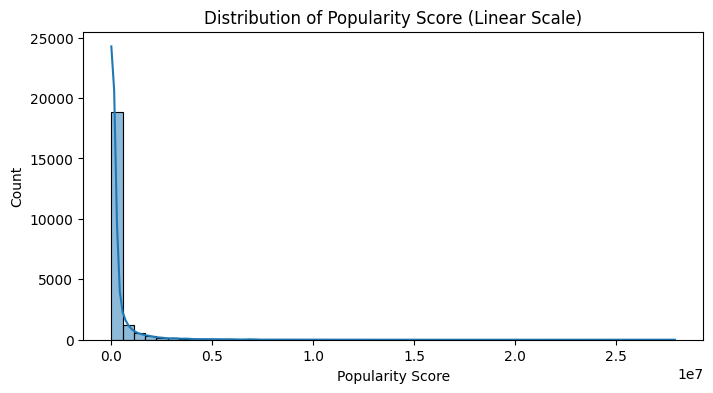

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 기본 히스토그램
plt.figure(figsize=(8, 4))
sns.histplot(movie_df['popularity_score'], bins=50, kde=True)
plt.title('Distribution of Popularity Score (Linear Scale)')
plt.xlabel('Popularity Score')
plt.ylabel('Count')
plt.show()

<Linear Scale (선형 스케일)>
- 극단적인 오른쪽 꼬리(long tail): 대부분의 영화가 낮은 인기도 점수에 몰려 있고, 소수의 영화만이 매우 높은 인기도 점수를 가지고 있음
- 심각한 오른쪽 왜도: 데이터가 왼쪽에 밀집되어 있고 오른쪽으로 길게 늘어져 있어 평균값만으로는 대표성을 설명하기 어려움
- 상위 인기 영화의 영향이 큼: 소수의 인기 영화가 전체 분포에 큰 영향을 미치는 것을 보임

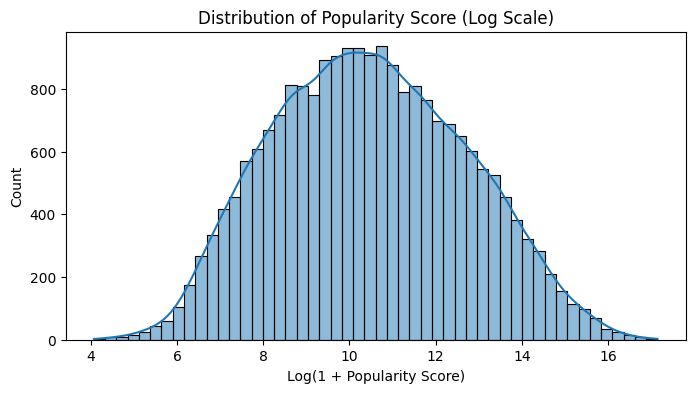

In [4]:
# 로그 변환 (0은 제외)
movie_df['popularity_score_log'] = movie_df['popularity_score'].apply(lambda x: np.log1p(x))

plt.figure(figsize=(8, 4))
sns.histplot(movie_df['popularity_score_log'], bins=50, kde=True)
plt.title('Distribution of Popularity Score (Log Scale)')
plt.xlabel('Log(1 + Popularity Score)')
plt.ylabel('Count')
plt.show()


<Log Scale (로그 스케일)>
- 정규분포에 가까운 형태: 로그 변환 후에는 인기도 점수가 중심을 기준으로 대칭적인 종형 곡선을 보임
- 해석 용이성 증가: 로그 변환을 통해 이상치의 영향을 줄이고, 대부분의 영화 인기도 패턴을 더 잘 관찰할 수 있음
- #### **모델링 준비 완료: 이처럼 정규화된 분포는 이후 회귀 분석에 용이**

## MPA (등급)별 평균 인기도 비교

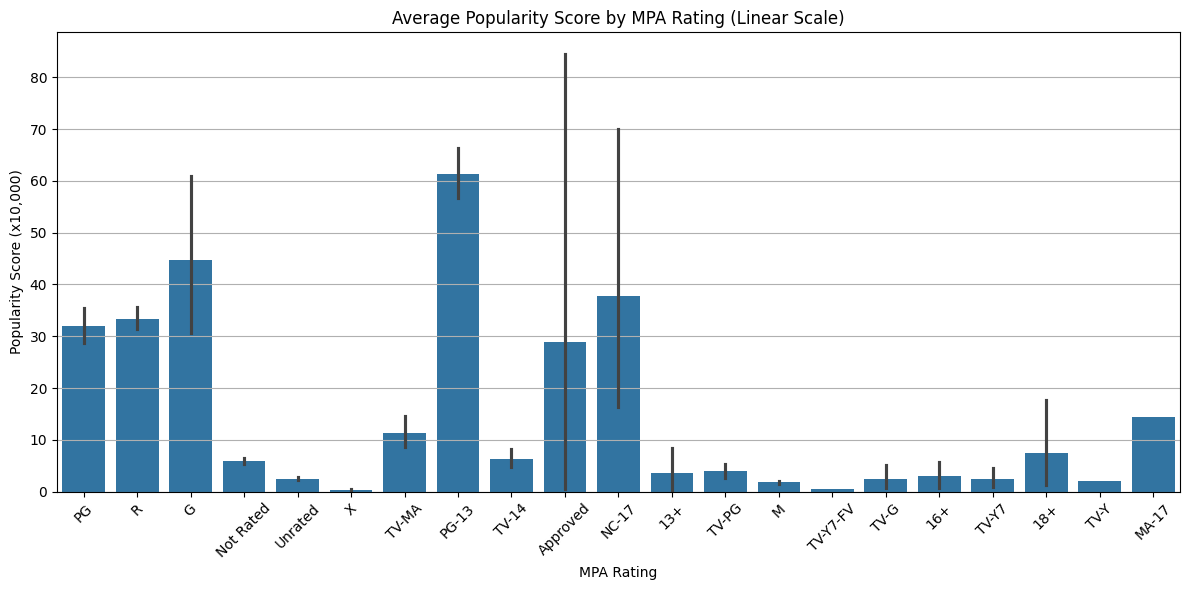

In [14]:
import matplotlib.ticker as ticker

plt.figure(figsize=(12, 6))
sns.barplot(data=movie_df, x='MPA', y='popularity_score')
plt.title('Average Popularity Score by MPA Rating (Linear Scale)')
plt.ylabel('Popularity Score (x10,000)')
plt.xlabel('MPA Rating')

# 숫자만 남기고 한글 제거- 10000 단위 단위로 축 표시)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x / 10000)}'))

plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

MPA 등급별 평균 인기도를 살펴본 결과, PG-13, G, NC-17, Approved 등급에서 비교적 높은 인기도를 보이며, 특히 PG-13이 가장 높은 평균 값을 기록함. 반면, X, TV-Y7-FV, M, TV-G 등 일부 등급은 인기도가 매우 낮음. 전반적으로 등급에 따라 인기도에 차이가 나타나며, **MPA 등급은 popularity_score와 유의미한 연관이 있는 변수임을 알 수 있음. 다만, 일부 등급은 표본 수가 적어 보이는 편차가 클 수 있으므로 해석 시 주의가 필요함.**

## 장르(genres_imdb)별 평균 인기도 분석

C:\Users\Playdata\AppData\Local\Temp\ipykernel_20720\1512643071.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_popularity.values / 10000, y=genre_popularity.index, palette='viridis')


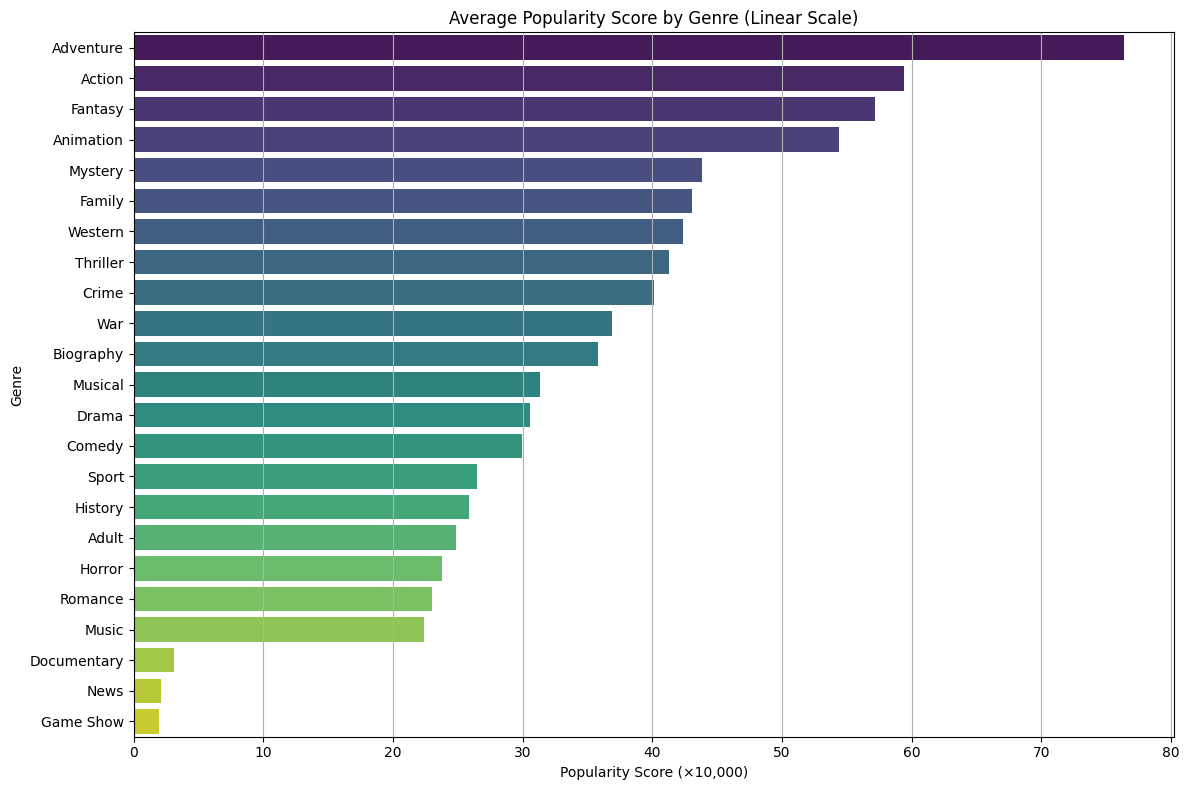

In [19]:
# 다대다 관계 해결을 위해 explode
movie_exploded = movie_df.explode('genres_imdb')

# 장르별 평균 인기도 계산 - 일반 스케일
genre_popularity = movie_exploded.groupby('genres_imdb')['popularity_score'].mean().sort_values(ascending=False)

# 장르별 평균 인기도 계산 - 로그 스케일
genre_popularity_log = movie_exploded.groupby('genres_imdb')['popularity_score_log'].mean().sort_values(ascending=False)

# 시각화 - 일반 스케일
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_popularity.values / 10000, y=genre_popularity.index, palette='viridis')
plt.title('Average Popularity Score by Genre (Linear Scale)')
plt.xlabel('Popularity Score (×10,000)')
plt.ylabel('Genre')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

장르별 평균 인기도를 살펴본 결과, 
Adventure, Action, Fantasy, Animation 장르가 상대적으로 높은 인기도를 보이는 반면, 
Game Show, News, Documentary는 낮은 인기도를 기록함. 장르에 따라 인기도에 뚜렷한 차이가 존재하므로, 
**장르는 popularity_score와 유의미한 연관이 있는 변수임을 알 수 있음**.

## 수치형 데이터 Heatmap

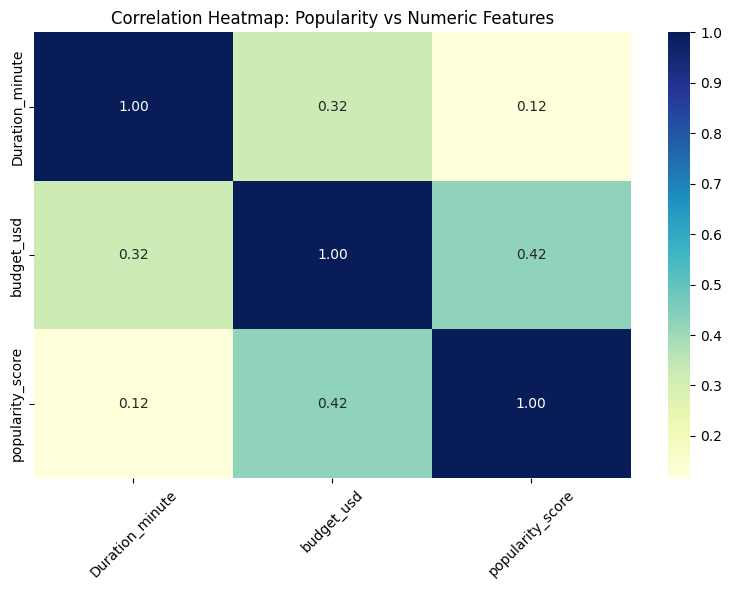

In [29]:
# 사용할 수치형 컬럼만 추출
num_cols = ['Duration_minute', 'budget_usd', 
            'popularity_score']

# 상관계수 계산
corr = movie_df[num_cols].corr(method='pearson')

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Heatmap: Popularity vs Numeric Features')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


- Votes와 Rating은 popularity_score를 계산할 때 사용한 수치들이므로 제외시킴
- 생각해보니 budget은 결측치가 반이나 되고, 예산은 배우들 섭외 비용 혹은 제작 비용에 영향을 미치는 요소니 **학습 시 특성에서 제외**